# Learning about two cues with the Kalman filter

See [Kruschke, 2008 Bayesian approaches to associative learning](https://link.springer.com/article/10.3758/LB.36.3.210) for a complete exposition. 

In the Kalman filter, the beliefs of the learner at any given moment can be summarized by the mean vector (mu) and the covariate matrix (C). Learning in the Kalman filter means shifting the degree of belief over all of the possible weight combinations to take into account the observed cues and outcomes. The updated equations for the mean and covariance of the beliefs have the following form (in Matlab syntax):  
  
`delta_mu = [v - c'Cc]^-1 .* (t - mu'c)Cc`  

`delta_C = -[v + c'Cc]^-1 .* Ccc'C`  

Where `t` is the actual outcome, and `c` is the column vector of cues present or absent on each trial (0 or 1). `v` is the outcome variance as well as a _free-parameter_ reflecting whether the environment is dynamic, i.e., in a dynamic environment trials in the distant past have less influence (and in a stationary environment `v = 0`). `C` is the belief uncertainty, and when `C` is larger then learning is faster.

Note that in the updating equation for the mean, `(t - mu'c)` is analagous to the prediction-error in the Rescorla-Wagner rule `(t - w'c)`. The Rescorla-Wagner learning rate (alpha) has been replaced by `[v - c'CC]`. Also note that in the Rescorla-Wagner rule, the weight of absent cues (when `c = 0`) does not change. In the Kalman filter, the delta is governed by the rightmost term (`Cc`), which is the cue vector multiplied by the covariance matrix. This implies that when a cue is absent, the mean weight on the cue might change if other cues are present which are (inversely) correlated with the absent cue.

#### A simulation
We start by defining ten trial events involving two cues and an outcome. Each cue can occur at random in each of ten trials, however the outcome always follows cue 1.

In [60]:
% trial events: two cues and a single outcome
cues = round(rand(10,2));             % (col1:cue1, col2:cue2)
outcome = cues(:,1);                  % generate outcome values 

% display cues and outcomes
disp('    cue1  cue2  outcome')
disp([cues,outcome])

    cue1  cue2  outcome
     0     0     0
     0     1     0
     1     1     1
     1     0     1
     0     0     0
     0     0     0
     0     1     0
     1     0     1
     1     1     1
     1     0     1



#### The Kalman filter

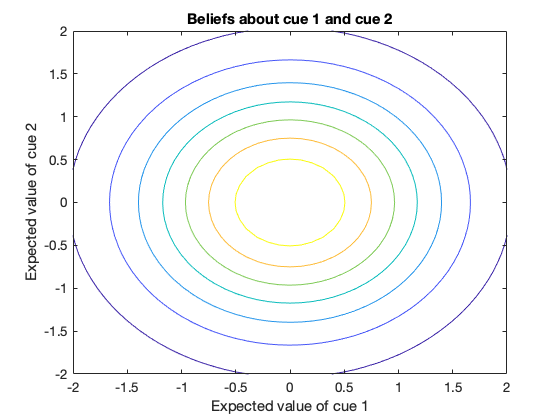

In [61]:
% define variables
alphas = [];
beliefs = [];
uncertainty = [];

% starting values
mu = [0,0]; % cue expected values (beliefs)
C = eye(2); % cue covariance matrix (uncertainty)
v = .5;    % observation uncertainty (how quickly variance reduces with trials)
d = 0;    % process uncertainty (variance floor)

% For plotting
x = -2:.1:2; % x axis
y = -2:.1:2; % y axis
[X Y] = meshgrid(x,y); %// all combinations of x, y
Z = mvnpdf([X(:) Y(:)],mu,C); %// compute Gaussian pdf
Z = reshape(Z,size(X)); %// put into same size as X, Y
contour(X,Y,Z)  %// contour plot; set same scale for x and y...
title('Beliefs about cue 1 and cue 2')
xlabel('Expected value of cue 1') 
ylabel('Expected value of cue 2') 

The starting beliefs about cue 1 and cue 2 are centred around zero for each. Note that we represent the belief about each cue as a bivariate relationship because in the Kalman filter both cues are always learnt about together. That is, updating the belief about one cue will usually result in updates to the other cue.

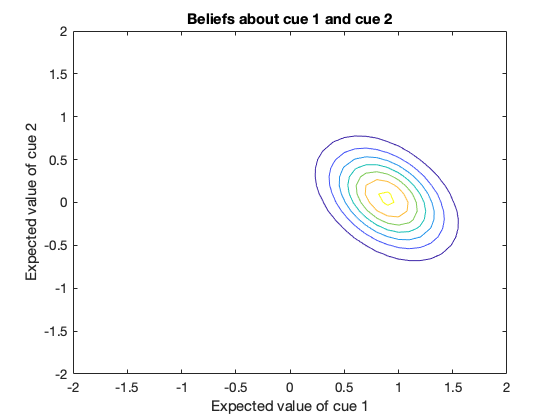

In [62]:
% kalman filter loop

for i = 1:size(cues,1)
    
    c = cues(i,:)';             % set cue values (transposed)
    t = outcome(i);             % set outcome values
    
    PE = (t - mu*c)*C*c;        % prediction-error
    alpha = (v + c'*C*c);       % uncertainty (outcome + expected)
%     alpha = (v + c'*C*c + sum(PE.^2)); % (outcome + expected + unexpected)
    delta_mu = 1/alpha*PE;      % calculate delta mu
    mu = mu + delta_mu';        % update mu

    
    cmatrix = C*(c*c')*C;       % adjust uncertainty by observed cues
    delta_C = 1/alpha*cmatrix;  % uncertainty reduction by observation
    C = C - delta_C+eye(2)*d;   % update C (reduce uncertainty)   
    
    %% store values
    alphas(end+1) = alpha;
    beliefs(end+1,:) = mu;
       
end

% For plotting
Z = mvnpdf([X(:) Y(:)],mu,C); % compute Gaussian pdf
Z = reshape(Z,size(X)); % put into same size as X, Y
contour(X,Y,Z)  % contour plot; set same scale for x and y...
title('Beliefs about cue 1 and cue 2')
xlabel('Expected value of cue 1') 
ylabel('Expected value of cue 2') 

By the end of training, the expected value of cue 1 is centered on E(V) = 1, while the expected value of cue 2 is still centered on E(V) = 0. However note that in both cases, the beliefs about the value are much narrower - the learner is more sure the E(V) in each case, and the slope of the elipsis tells us the E(V)s are inversely correlated.

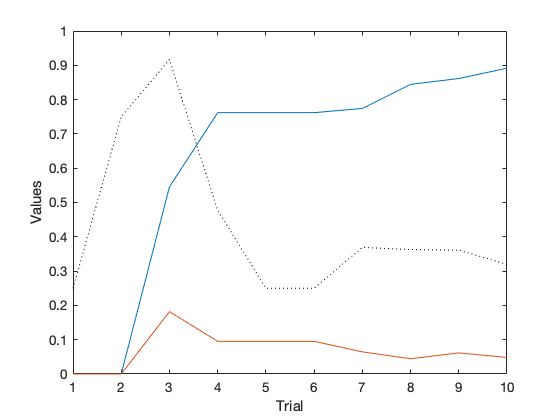

In [63]:
% plot V-values (red is cue2, blue is cue1, dotted is total uncertainty)
plot(beliefs); hold on
plot(alphas./2,'k:'); hold off
xlabel('Trial') 
ylabel('Values') 

Plotting the changes in cue value across trials shows how the model learns about each cue together. Note that in this example, cue 2 occurred without any other events in trial 2, and then both cues occurred with the outcome in trial 3 and the model attributed greater value to cue 1 as a result. This occurred because of the negative covariation detected between cue 1 and cue 2 on trial 2.

Compare to the Rescorla-Wagner model below.

#### The Rescorla-Wagner model

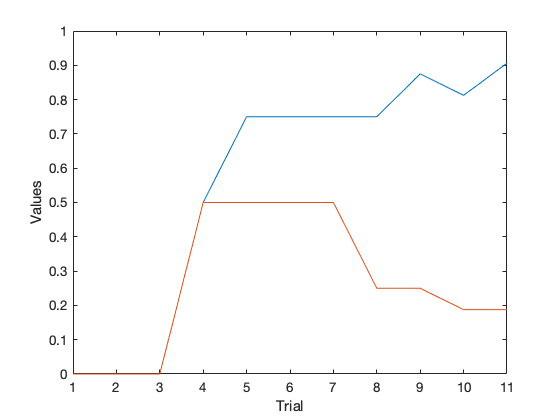

In [64]:
% starting values
alpha = 0.5; w = [0,0];

%% rescorla-wagner model loop
for i = 1:size(cues,1)
    
    c = cues(i,:);
    t = outcome(i);
    
    sumV = w(i,:)*c';
    delta_w = alpha*(t-sumV);
    w(end+1,:) = w(i,:)+delta_w*c;
    
end
    
% plot V-values (red is cue2, blue is cue1)
figure(2)
plot(w)
ylim([0 1])
xlabel('Trial') 
ylabel('Values') 

Comparing the changes in learning here with the Kalman filter above shows that trial 2 produced no learning about either cue. On trial 3, both cues were learned about equally, and it isn't until trial 4 that the model can distinguish the difference between the cues.